# Lending club investment project

The dataset for this project is a Lending Club dataset (in a pkl format).

The main objectives are to build two investment strategies for a potential investor who wants to invest in the lending club platform. 

The first investment strategy is based on maximizing return. In order to do that, we define what return means in this context and how it is calculated. In the dataset, there are five columns named "ret_PESS, ret_OPT, ret_INTa, ret_INTb, ret_INTc". These are some calculated returns based on some definitions, and are not used in the analysis. 

Second investment strategy is based on minimizing default. In order to do this, I create a predictive default model. The aim of this investment strategy is to build a portfolio that achieves the minimum default.

Ultimately, for a given natural number $N$, my methodology comes up with two portfolios made of $N$ loans, one based on the first investment strategy, achieving the highest return, and the other based on the second strategy, achieving the minimum default risk  where I clarify the precise meanings of 'return' and 'default'.

For each investment strategy, I build two predictive models, and of these two models for each investment strategy, one of them is an artificial neural network (ANN).


The structure of the report is as follows:

1) Introduction 

2) Data Exploration 

3) Investment Strategy Based on Return Maximizing

4) Investment Strategy Based on Default Minimization

5) Experiments and Results

6) Conclusions 

7) Acknowledgment

8) References

9) Appendices


# 1. Introdution

This project puts us in the shoes of a Lending club investor looking to lend money to people (invest in loans). We will explore two different investment strategies - first based on return maximization and the second based on default minimization. To implement the strategies, we will train many machine learning models to learn the connection between explanatory data and the target variable (return for strategy 1 and default for strategy 2), choose the best ones based on their performance on an unseen validation set and finally evaluate them on the test set. For the sake of the experiment, we assume that the investor is constrained only by the ammount of loans they are able to make and not by the size of the loans, hence we do not take the size of loans into account when calculating the return of the loan or the default. If the investors was constrained by the actual ammount of loans as well, we could simply take that into account by multiplying the target variables (which we will calculate later on) with the loan ammount.

# 2. Data Exploration

Data contains no missing values

Dataset contains 33 columns. Of those, 1 is a unique "id" column, 5 columns are target columns (ret_xxx), 3 columns are technically string but in reality are dates ("last_pymnt_d", "earliest_cr_line", and "issue_d"), 6 columns are factor variables, 13 columns are continuous features. However, discrete_features list is missing loan_status variable and continuous_variables list is missing c variables. These variables are missing as they are ex-post variables, and using them in modelling would be time-inconsistent. term_num variable is also missing from continuous_factors becaue its discrete twin is already recorded in the term variable.

None of the continuous variables are normally distributed (see Appendix/Data exploration/Histograms section). All of them have right or left skew and some even exhibit bi-modality (e.g. loan_length). Some categorical variables are balanced and some are unbalanced (see Appendix/Data exploration/Pie charts section). Some variables are very correlated with each other (Appendix/Data exploration/Correlaion matrix section) and are removed from the training data to avoid co-linearity issues when training the models. Variables that were dropped are "loan_amnt", "funded_amnt", "fico_range_high" as they have >0.95 correlation with other variables. A new variable has been created called "installment_pct_of_inc" which represents the loan repayment percentage of that person's income. 

# 3. Investment Strategy based on Return Maximizing

## 3.1 Return definition:

Raw return is defined as the difference between the total repayment a person has made on the loan and the ammount funded divided by the ammount funded and the time it took that person to repay the loan ((total_payment - funded_amount) / funded_amount / (loan_length / 12)). However, This figure needs to be adjusted for the risk rating of the loan. Based on the risk grading of the borrower (grade), a risk premium is deducted from the calculation of the return. Risk premiums based on "grade" are completely subjective and could be modified by the user of the model according to their beliefs about risk premiums. TheyFor the sake of this experiment, they go as follows:

risk_premiums = {
    'A': 0.005,
    'B': 0.01, 
    'C': 0.02, 
    'D': 0.03, 
    'E': 0.045, 
    'F': 0.06, 
    'G': 0.08 
} 

By deducting risk premium from the raw return calculation, we get the target variable for this task: "risk_adjusted_return".

!!!Important note!!!: none of the variables used for raw return calculation nor "loan_status" are used for model training.

## 3.2 Data Preprocessing:

Firstly, the data is split into the training (60%), validation(20%) and test (20%) sets. Categorical-explanatory variables are one-hot encoded, the standard scaler is fit on the training-continuous-variables and then used to scale validation- and test-continuous-variables.

## 3.3 Experiment Configuration:

### 3.3.1 Models:

Neural network and Regression tree models will be used to learn the relationship between explanatory and target variables 

### 3.3.2 Hyperparameter optimization:

Neural network is experimented on using 3 different parameters: number of hidden layers (1 or 2), number of neurons in each hidden layer (10, 20, ..., 100) and activation function (ReLU vs sigmoid). (See section Appendix / Return Maximization / Neural Network implementation)

Regression tree is experimented on by changing the min_impurity_decrease parameter. (See section Appendix / Return Maximization / Regression Tree implementation)

Each possible configuration of both these two models is trained on the training set (60%) and evaluated on the validation set (20%). Based on the performances on the validation set, the best version of each model is then evaluated on the test set (20%). Evaluation (and selection) of the models is done based on MSE metric. This is also implemented in the last two mentioned sections. 

## 3.4 Investment strategy

For a given dataset, the models will make regression predictions about returns of the loans in the set. These predictions are then sorted from highest to lowest and we chose the N loans whos' returns are predicted to be the highest. 

### 3.4.1 Investment strategy evaluation

The predicted return of the loans we picked IS NOT important, rather the ACTUAL/REAL return of the top N loans picked by the models is important. Given the top N loans predicted by the models, we check their actual returns and sum them up (to let's say s and s is a function of N: s(N)). 

For a given test set and a number N, if one had perfect knowledge/information, one could make the perfect pick of top N loans with highest risk_adjusted_return. These top N loan returns sum up to a certain number (let's say s* and s* is a function of N: s*(N)).

The metric of our loan-picking performance, for a given number N, is measured by sum of model-picked top N ACTUAL returns as percentage of the sum of perfect-pick top N returns i.e. s(N)/s*(N). Intuitively: If the models learn the relationship between explanatory data and loan returns perfectly, then the top N models according to our models' predictions will be the same as perfect-pick top N models and our performance will be s/s* = 1.

The calculation of this metric is done with the "evaluate_ranking(truth, prediction, n)" helper function from the beginning of the section: (Appendix / Return Maximization / Neural Network Implementation).

## 3.5 Baseline strategy

Baseline strategy is simply picking loans at random. Expected return of a randomly-picked set of loans is the average return of all loans. However, same as our investment strategy, the baseline return needs to be evaluated as the percentage of the mean of the perfect-pick top N returns. As N changes, the mean return of top N loans decreases (by definition), hence, the performance of the baseline changes with N: mean(all_returns) / s*(N).

Calculation of the baseline strategy performance is done in section: (Appendix / Return Maximization / Model comparison).


# 4. Investment Strategy based on Default Minimization

## 4.1 Default definition:

Loans classified as Default are those whos' "loan_status" variable is either "Charged Off" or "Default"

## 4.2 Data Preprocessing:

Same as previously, data is split into the training (60%), validation(20%) and test (20%) sets. Categorical-explanatory variables are one-hot encoded, the standard scaler is fit on the training-continuous-variables and then used to scale validation- and test-continuous-variables. Additionally, training-validation-test sampling is stratified to retain the same proportion of defaults to non-defaults. (see Appendix / Default Minimization / Data pre-processing)

!!!Important note!!!: none of the variables used for raw return calculation nor "loan_status" are used for model training.

## 4.3 Experiment Configuration:

### 4.3.1 Models:

Neural network and Regression tree models will be used to learn the relationship between explanatory variables and loan default. 

### 4.3.2 Hyperparameter optimization:

Neural network is experimented on using 2 different parameters: number of hidden layers (1 or 2) and number of neurons in each hidden layer (10, 20, ..., 100). (See section Appendix / Default Minimization / Neural Network implementation)

Regression tree is experimented on by changing 2 hyperparameters: the min_sample_splits and min_sample_leafs. (See section Appendix / Default Minimization / Decision Tree implementation)

Each possible configuration of both these two models is trained on the training set (60%) and evaluated on the validation set (20%). Based on the performances on the validation set, the best version of each model is then evaluated on the test set (20%). Due to the specific nature of the task, evaluation (and selection) of the models is done based on the Recall metric. This is because we want to catch as many defaulting loans as possible - in order to avoid them i.e. we aren't worried about misclassifying non-defaults (false positives) and we are quite worried about misclassifying defaults (false negatives).

## 4.4 Investment strategy

Even thought the nature of these models is for binary classification, for a given set of loans, the models will output the probabilitiy for each loan being default. These probability predictions are then sorted from lowest to highest and we pick N loans with the lowest probability of going default.

### 4.4.1 Investment strategy evaluation

Similarly as in the previous strategy, we rank all loans by their probability of default from lowest to highest and we pick N loans with lowest predicted default probability. Then we look at whether they actually are default or not (ground truth) and we calculate the default rate of the set of our N picked models according to ground-truth.

The calculation of this metric is done with the use of helper function "evaluate_default_rate(truth, prediction, n)" from section: (Appendix / Return Maximization / Neural Network Implementation).

## 4.5 Baseline strategy

Baseline strategy is simply picking loans at random. Expected default rate of a set of randomly picked loans is equal to the ammount of defaulting loans divided by total number of loans. It doesn't depend on N and is therefore constant.

Calculation of the baseline strategy performance is done in section: (Appendix / Default Minimization / Model comparison).

# 5. Experiments and Results

As mentioned in the previous section, experimentation was done by training models with different hyperparameter configurations. 

## 5.1 Return Maximization

### 5.1.1 Neural network Experimentation

(See section: Appendix / Return Maximization / Neural Network experimentation and result) 

Generally, the best performing Neural network is the sigmoid two-layer (red). It is followed closely by sigmoid single-layer version (green) and ReLU single layer version (blue). ReLU double layer network performs quite well with low number of neurons but it seems to get much worse, the more neurons it has per hidden layer.

Overall, the best performing neural network is the 100 neuron-per-layer Sigmoid double-layer version.

Loss seems to be decreasing very gradually with number of training epochs and it is interesting to note that the best neural network's performance seems to be better on the validation set than on the training set.

### 5.1.2 Regression tree Experimentation

Best performing regression tree is the one with 0.01 min_impurity_decrease hyperparameter.

### 5.1.3 Comparison and evaluation

(See section: Appendix / Return Maximization / Model comparison) 

The best neural network has a lower MSE on the test set (0.5972) than the best regression tree does (0.6075) - meaning that the neural network is generally a better regression model. 

When we compare the performance of insvestment strategies (outlined in section 3) based on neural network (blue line) against the one based on regression tree (orange line), we get very interesting result: For low levels of N (up to about 20), decision tree seems to be quite good at picking loans with high return - achieving the relative performance (relative to perfect-pick) between 9% and 18%. However, from the very beginning, the regression tree's performance seems to drop in a volatile fashion with increasing N untill it relatively stabilizes at around -5% at n=400.

Neural network is particularly bad in the low range of N (0 < N < 10) - even picking loans with significantly negative returns (between -60% and 0%). For N > 20 the neural network outperforms the regression tree and its performance peaks at 10% for (20 < N < 120). At approximately N=150, neural network performance slumps (it probably makes a big mistake with one or few loans) and it asymptotically approaches back to 10% from then on.

Baseline strategy (red dashed line) is quite bad as the average loan return is negative (probably due to risk premium deduction in the return definition). This is visible in the graph in (Appendix / Return Maximization / Model comparison). Interesting to note that the investment strategy based on either of the two machine learning models significantly beats the baseline strategy - even by almost 60 percentage points in neural network case, for n=1000.



## 5.2 Default Minimization

### 5.2.1 Neural network Experimentation

(See section: Appendix / Defaul Minimization / Neural Network experimentation and result) 

FSigmoid double-layer configuration outperforms its single-layer counterpart for every number of neurons in hidden layer (in terms of binary cross-entropy) and the best version in terms of number of neurons is the 70 neuron one. However, due to the nature of the task, we chose the model with the highest validation recall - which is sigmoid double-layer 100 neuron version.

Training loss on the sigmoid 100 neuron double-layer network drops significantly in the first epoch and then slowly decreases in the following epochs. Validation loss is consistently higher than training loss, as expected.

The best neural network achieves slightly higher accuracy (0.7950) than (baseline) majority class predictor (0.7886) and a recall of 0.1440 vs majority class predictor recall of 0.00.
### 5.2.2 Regression tree Experimentation

Best performing regression tree is the one with min_sample_split: 2 and min_sample_leaf: 1.

### 5.2.3 Comparison and evaluation

(See section: Appendix / Return Maximization / Model comparison)
(See section: Appendix / Return Maximization / Decision tree evaluation)

The best neural network achieves slightly higher test accuracy (0.7950) than the majority class predictor (0.7886) and a test recall of 0.1440 vs majority class predictor recall of 0.00. The best Classification tree model achieves significantly worse test accuracy (0.6941) than the majority class predictor (0.7886), however, it achieves much better test recall than the best neural network at 0.3189 vs 0.1440. Because the best configuration of the models are picked based on recall and because its accuracy is so much worse than the majority class predictor's, the best tree model is probably a bit biased towards predicting default - which is not a problem in our case as we want to maximize recall.

Since ~ 21% of loans in the dataset are default, if we implement a random pick strategy, we can expect that ~21% of our portfolio will be defaults (red dashed line). Our goal is to be able to pick loans so that our default rate is under 21%. Both of our investment strategies achieve that. for all N apart from N=length(test set) because then we pick the whole dataset basically. 

When we compare the performance of insvestment strategies (outlined in section 4) based on neural network (blue line) against the one based on regression tree (orange line), we see that the neural network - based strategy SIGNIFICANTLY outperforms the classification tree - based strategy. There seems to be almost perfect linear relationship between N and neural network strategy default rate: the higher the N, the higher the default rate. Starting from ~1% for low levels of N, its default rate linearly climbs to 21% at N=121,000 (size of the test set is ~121,000). Classification tree strategy performs OK for very small Ns, but its' default rate increases very steeply early on and stabilizes at ~18% (just 3 percentage points better than baseline) at N=20,000, slowly starting to increase after N=95,000.


# 6. Conclusions

Overall, all 4 of our ML-based investment strategies beat the benchmark strategy in pretty much all respects across all ranges of N. In some cases, they perform much better than the baseline (for example neural network return maximization high N scenario) and in some cases they perform just slightly better than baseline (classification tree default minimization scenario) Generally, the neural network - based investment strategies seem to be dominating their tree-based counterparts (apart from return maximization, N<20 scenario). This is most evident in the default minimization strategy but is also quite clear in return maximization.

We can also say that the neural networks that perform better are the ones that have two layers, more neurons and sigmoid activation. An area for future experimentation could include training neural networks with even more layers and more neurons per layer. 

An interesting result is that (in default minimization scenario) even though classification tree's recall is more than twice as high as neural network's, the classification tree - based strategy performs MUCH worse than neural network. This is a bit counter intuitive as one would expect a model with higher recall to have smaller chances of picking default loans, but in reality this doesn't seem to be the case. This is probably due to the overfitting nature of the classification tree. Neural network is able to make a much more nuanced and generalized prediction about probability of default - which is good for ranking of the models, whereas the tree is statistically more correct but is too confident when predicting defaults which is very bad in this scenario because the RANKING of the loans default probability is what matters, and not the actual recall of prediction. 

# 7. Acknowledgement

LLMs were used in this project for the purposes of making the code look more neat and adding explanatory comments to certain sections of the code.

# 8. References 

# 9. Appendices

In [1]:
# load libraries and utilities
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='keras.*')


In [2]:
# Loading the dataset

with open("lending_club_dataset.pickle", 'rb') as file:
    data, discrete_features, continuous_features = pickle.load(file)

In [3]:
discrete_features

['home_ownership',
 'grade',
 'emp_length',
 'purpose',
 'verification_status',
 'term']

In [4]:
seed = 99

## 2. Data Exploration

In [5]:
pd.set_option('display.max_columns', None)
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,14.25,0.0,2010-07-01,7.0,0.0,674.0,670.0,5994.0,44.4,5475.14000,2015-12-01,0.0,10.973531,36,0.031676,0.103917,0.031155,0.050634,0.086751
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,21.31,0.0,2006-09-01,12.0,0.0,684.0,680.0,14690.0,73.1,20452.09912,2018-03-01,0.0,37.947391,36,0.067688,0.064215,0.050574,0.066334,0.094950
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,Source Verified,2015-01-01,Fully Paid,credit_card,24.80,0.0,1982-11-01,10.0,0.0,719.0,715.0,26172.0,77.7,9792.56000,2015-11-01,0.0,9.987885,36,0.029354,0.105803,0.029798,0.049345,0.085622
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,18.41,0.0,2001-04-01,11.0,0.0,664.0,660.0,14330.0,34.8,16592.91130,2018-01-01,0.0,36.008953,36,0.061736,0.061721,0.047093,0.063007,0.091937
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,Verified,2015-01-01,Fully Paid,debt_consolidation,13.73,0.0,1999-03-01,12.0,0.0,709.0,705.0,5947.0,44.1,15122.07997,2018-10-01,0.0,44.978336,60,0.102442,0.136655,0.113866,0.131897,0.164518


In [6]:
# data types in the dataset
data.dtypes

id                      object
loan_amnt              float64
funded_amnt            float64
term                    object
int_rate               float64
installment            float64
grade                   object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
issue_d                 object
loan_status             object
purpose                 object
dti                    float64
delinq_2yrs            float64
earliest_cr_line        object
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
revol_bal              float64
revol_util             float64
total_pymnt            float64
last_pymnt_d            object
recoveries             float64
loan_length            float64
term_num                 int32
ret_PESS               float64
ret_OPT                float64
ret_INTa               float64
ret_INTb               float64
ret_INTc

In [7]:
# all variables with their min-max values (if numerical) or possible values (if discrete)
ignore_columns = ['id', 'last_pymnt_d', 'earliest_cr_line', 'issue_d']
for column in data.columns:
    if column in ignore_columns:
        continue  
    column_dtype = data[column].dtype
    print(f"Column '{column}':")

    if column_dtype in ['int64', 'float64']:
        min_val = data[column].min()
        max_val = data[column].max()
        print(f"    Type: Numeric ({column_dtype})")
        print(f"    Range: {min_val} to {max_val}")
    else:
        unique_values = data[column].unique()
        print(f"    Type: Object ({column_dtype})")
        print(f"    Unique Values:")
        for value in unique_values:
            print(f"        {value}")


Column 'loan_amnt':
    Type: Numeric (float64)
    Range: 1000.0 to 40000.0
Column 'funded_amnt':
    Type: Numeric (float64)
    Range: 1000.0 to 40000.0
Column 'term':
    Type: Object (object)
    Unique Values:
         36 months
         60 months
Column 'int_rate':
    Type: Numeric (float64)
    Range: 5.31 to 30.99
Column 'installment':
    Type: Numeric (float64)
    Range: 14.01 to 1719.83
Column 'grade':
    Type: Object (object)
    Unique Values:
        C
        B
        E
        A
        D
        F
        G
Column 'emp_length':
    Type: Object (object)
    Unique Values:
        < 1 year
        1 year
        6 years
        10+ years
        2 years
        3 years
        5 years
        7 years
        4 years
        8 years
        9 years
        None
Column 'home_ownership':
    Type: Object (object)
    Unique Values:
        RENT
        MORTGAGE
        OWN
        ANY
        NONE
Column 'annual_inc':
    Type: Numeric (float64)
    Range: 16.0 to 955

### Histograms

In [ ]:
# histograms of all numerical values
numeric_columns = data.select_dtypes(include=['int64', 'float64'])
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=50, kde=True, color='blue', edgecolor='black',  kde_kws={'bw_adjust': 3})
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Pie charts

In [ ]:
# pie chart of all discrete variables
ignore_columns = ['id', 'last_pymnt_d', 'earliest_cr_line', 'issue_d']
categorical_columns = data.select_dtypes(include=['object']).columns.drop(ignore_columns)
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    value_counts = data[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'{column} variable instances')
    plt.show()


### Correlation matrix

C:\Users\topco\AppData\Local\Temp\ipykernel_9240\2190198486.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = d.corr()


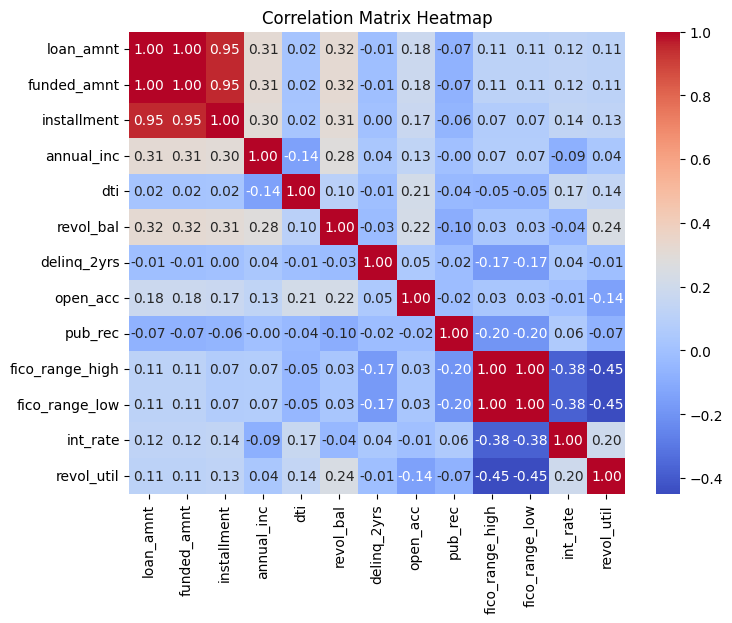

In [10]:
# correlation matrix
d = data[continuous_features + discrete_features]
correlation_matrix = d.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

### Data preprocessing

In [11]:
# return definition

risk_premiums = {
    'A': 0.005,
    'B': 0.01, # +0.005
    'C': 0.02, # +0.01
    'D': 0.03, # +0.01
    'E': 0.045, # +0.015
    'F': 0.06, # +0.015
    'G': 0.08 # +0.02
}

def calculate_adjusted_return(row):
    total_payment = row['total_pymnt']
    funded_amount = row['funded_amnt']
    loan_length = row['loan_length']
    grade = row['grade']
    raw_return = (total_payment - funded_amount) / funded_amount / (loan_length / 12)
    risk_adjusted_return = raw_return - risk_premiums[grade]
    return risk_adjusted_return

data['risk_adjusted_return'] = data.apply(calculate_adjusted_return, axis=1)

In [12]:
# converting all categorical variables to "category" data type for faster processing
for column in discrete_features:
    if data[column].dtype == 'object':
        data[column] = data[column].astype('category')
data_encoded = pd.get_dummies(data, columns=discrete_features)

# dropping non-explanatory variables
data_to_exclude = list(set(data.columns) - (set(discrete_features) | set(continuous_features)))
x = data_encoded.drop(columns = data_to_exclude)

# dropping highly correlated variables
x = x.drop(columns = ["loan_amnt", "funded_amnt", "fico_range_high"])
continuous_features_reduced = [x for x in continuous_features if x not in ["loan_amnt", "funded_amnt", "fico_range_high"]]

# creating a new variable
x["installment_pct_of_inc"] = x.installment / x.annual_inc

y = data_encoded.risk_adjusted_return

In [13]:
# data splitting and scaling
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = seed) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = seed)

scaler = StandardScaler()

x_train_scaled = x_train
x_test_scaled = x_test
x_val_scaled = x_val

x_train_scaled[continuous_features_reduced] = scaler.fit_transform(x_train[continuous_features_reduced])
x_test_scaled[continuous_features_reduced] = scaler.transform(x_test[continuous_features_reduced])
x_val_scaled[continuous_features_reduced] = scaler.transform(x_val[continuous_features_reduced])

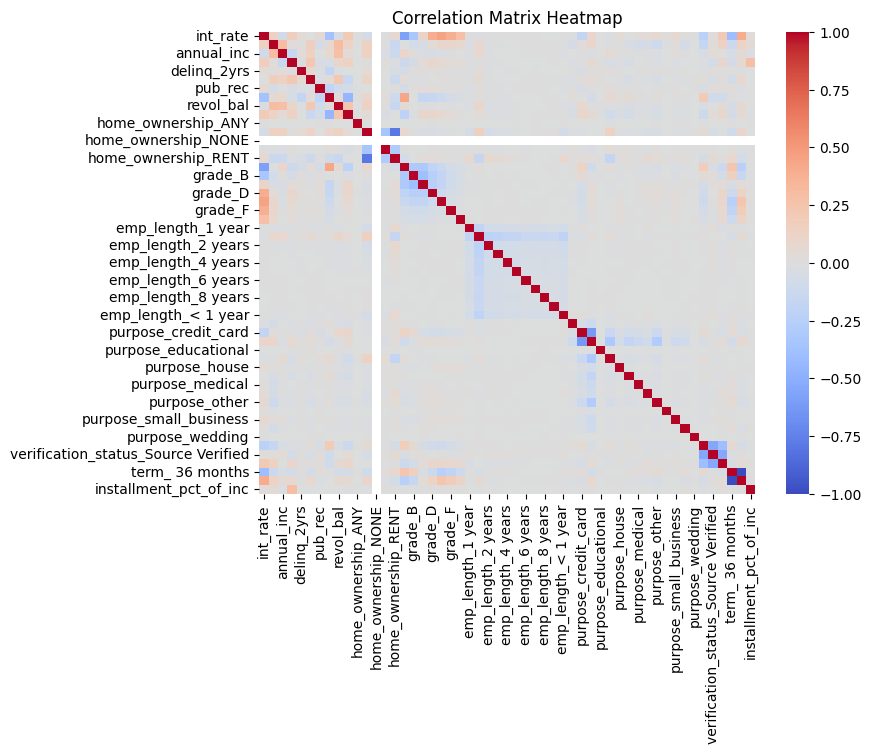

In [14]:
correlation_matrix = x_train_scaled.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

## 3. Return Maximization

### Neural Network Implementation

In [15]:
# helper functions

def get_top_n_values(data, column, n):
    sorted_data = data.sort_values(by=column, ascending=False)
    top_n_values = sorted_data.head(n)[column].tolist()
    return top_n_values

def get_lowest_n_indices(values, n):
    sorted_indices = np.argsort(values)[:n]
    original_indices = [values.index[i] for i in sorted_indices]
    return original_indices

def evaluate_ranking(truth, prediction, n):
    prediction = prediction.flatten()
    top_n_true = np.sort(truth)[::-1][:n]
    top_n_predicted_indices = truth.index[np.argsort(prediction)[-n:][::-1]]
    top_n_predicted_values = truth[top_n_predicted_indices]
    return (np.sum(top_n_predicted_values) / np.sum(top_n_true))

def evaluate_default_rate(truth, prediction, n):
    lowest_indices = np.argsort(prediction.flatten())[:n]
    selected_truth_values = truth[truth.index[lowest_indices]]
    average_of_selected = np.sum(selected_truth_values) / n
    return average_of_selected

In [16]:
# neural network helper functions

def create_model(n_neurons, activation, num_layers=1, loss = 'mean_squared_error', classification = False):
    model = Sequential([
        Dense(n_neurons, activation=activation, input_shape=(x_train_scaled.shape[1],))
    ])
    for _ in range(1, num_layers):
        model.add(Dense(n_neurons, activation=activation))
    if classification:
        model.add(Dense(1, activation = "sigmoid"))
    else:
        model.add(Dense(1))
    model.compile(optimizer='adam', loss=loss)
    return model

def train_models(models_list, x_train_scaled, y_train, epochs = 20, batch_size = 1000):
    histories = []
    for model in models_list:
        history = model.fit(x_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose = False)
        histories.append(history)
    return histories

def evaluate_models(models_list, x_val_scaled, y_val):
    validation_losses = []
    for model in models_list:
        validation_losses.append(model.evaluate(x_val_scaled, y_val, verbose=0))
    return validation_losses

def calculate_recalls(models_list, x_val_scaled, y_val):
    validation_recalls = []
    for model in models_list:
        val_prediction = model.predict(x_val_scaled)
        val_prediction = (val_prediction >= 0.5).astype(int)
        validation_recalls.append(recall_score(y_val, val_prediction))
    return validation_recalls


In [17]:
random.seed(seed)
# Dictionary to hold models
model_dict = {
    'ReLU Single Layer': [],
    'ReLU Double Layer': [],
    'Sigmoid Single Layer': [],
    'Sigmoid Double Layer': []
}

# Create models with varying numbers of neurons
for n_neurons in range(10, 110, 10):
    model_dict['ReLU Single Layer'].append(create_model(n_neurons, 'relu', 1))
    model_dict['ReLU Double Layer'].append(create_model(n_neurons, 'relu', 2))
    model_dict['Sigmoid Single Layer'].append(create_model(n_neurons, 'sigmoid', 1))
    model_dict['Sigmoid Double Layer'].append(create_model(n_neurons, 'sigmoid', 2))

# Training and evaluating models
model_histories = {}
model_val_losses = {}

for key in model_dict:
    model_histories[key] = train_models(model_dict[key], x_train_scaled, y_train)
    model_val_losses[key] = evaluate_models(model_dict[key], x_val_scaled, y_val)

# Flatten the model dictionary into a single list for easy indexing
all_models = [model for model_list in model_dict.values() for model in model_list]
all_validation_losses = [loss for loss_list in model_val_losses.values() for loss in loss_list]

# Find the index of the model with the lowest validation loss
best_model_index = np.argmin(all_validation_losses)
best_nn_model = all_models[best_model_index]
best_validation_loss = all_validation_losses[best_model_index]

# Determine the type and specifics of the best model
model_types = list(model_dict.keys())
models_per_type = len(model_dict['ReLU Single Layer'])  
best_model_type = model_types[best_model_index // models_per_type]
best_model_neurons = 10 * ((best_model_index % models_per_type) + 1) 

# Print the best model details
print(f"Best Model Type: {best_model_type}")
print(f"Best Model Neurons: {best_model_neurons}")
print(f"Best Validation MSE: {best_validation_loss}")

# Evaluate the best model on the test set
test_loss = best_nn_model.evaluate(x_test_scaled, y_test, verbose=0)
print(f"Test MSE: {test_loss}")






Best Model Type: Sigmoid Double Layer
Best Model Neurons: 100
Best Validation MSE: 0.5741037726402283
Test MSE: 0.5971904397010803


In [18]:
y_test_nn_predicted = best_nn_model.predict(x_test_scaled)

3784/3784 [==============================] - 3s 794us/step


### Neural Network experimentation and result 

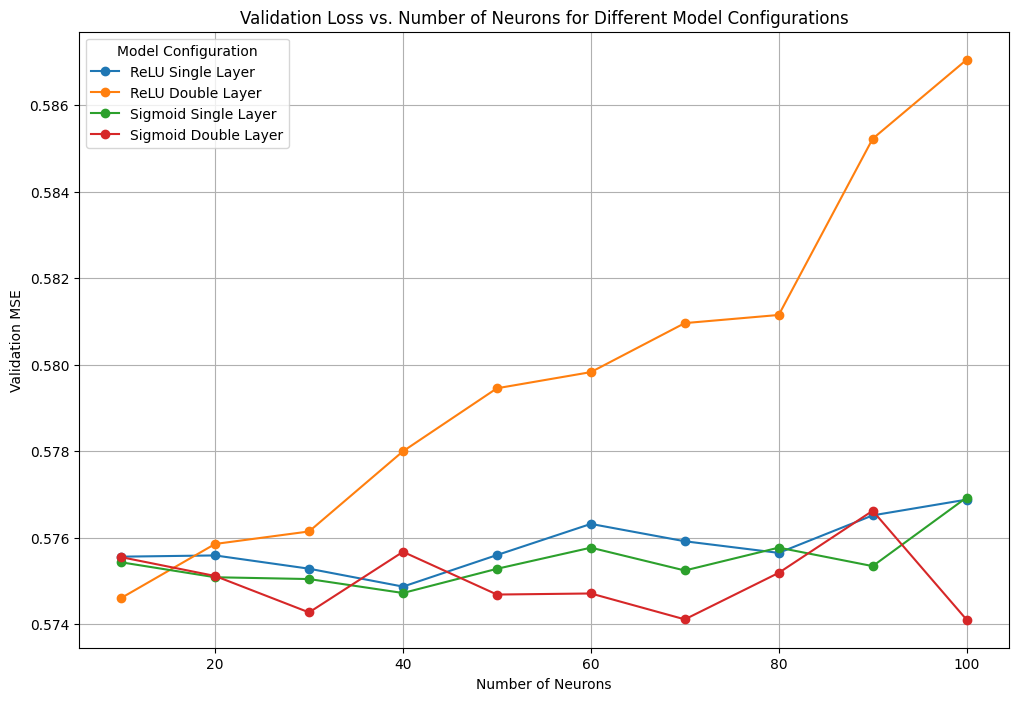

In [19]:
neurons = list(range(10, 110, 10))
plt.figure(figsize = (12, 8))

# plotting validation losses for each model configuration
for key, losses in model_val_losses.items():
    plt.plot(neurons, losses, label = f'{key}', marker = 'o')
plt.title('Validation Loss vs. Number of Neurons for Different Model Configurations')
plt.xlabel('Number of Neurons')
plt.ylabel('Validation MSE')
plt.legend(title='Model Configuration')
plt.grid(True)
plt.show()


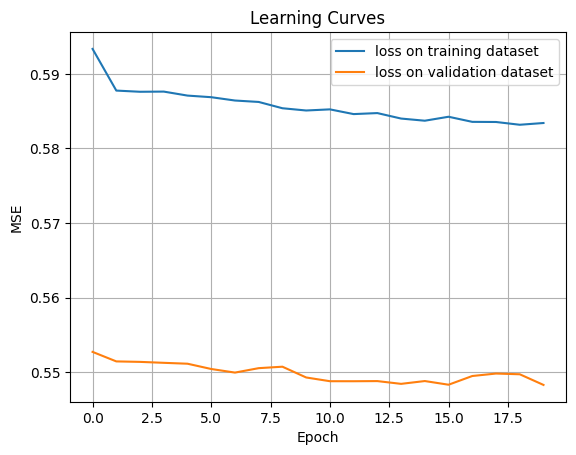

In [20]:
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(model_histories[best_model_type][(best_model_neurons / 10 - 1).astype(int)].history['loss'], label = 'loss on training dataset')
pyplot.plot(model_histories[best_model_type][(best_model_neurons / 10 - 1).astype(int)].history['val_loss'], label = 'loss on validation dataset')
pyplot.legend()
plt.grid(True)
pyplot.show()

### Regression Tree implementation and Evaluation

In [21]:
tree_models = []

best_tree_model = None
best_validation_error = float('inf')

# values to experiment with for min_impurity_decrease
min_impurity_decrease_values = [0.0, 0.01, 0.02, 0.05]

# grid search
for impurity_decrease in min_impurity_decrease_values:
    reg_tree = DecisionTreeRegressor(min_impurity_decrease=impurity_decrease)
    reg_tree.fit(x_train_scaled, y_train)
    y_pred_validation = reg_tree.predict(x_val_scaled)
    validation_error = mean_squared_error(y_val, y_pred_validation)
    tree_models.append((reg_tree, validation_error))
    if validation_error < best_validation_error:
        best_tree_model = reg_tree
        best_validation_error = validation_error
        best_impurity_decrease = impurity_decrease

y_test_tree_predicted = best_tree_model.predict(x_test_scaled)
test_error = mean_squared_error(y_test, y_test_tree_predicted)
print(f"Best validation MSE: ", best_validation_error)
print("Test MSE:", test_error)
print(f"Best performing model used min_impurity_decrease: {best_impurity_decrease}")


Best validation MSE:  0.5862262929867668
Test MSE: 0.607517312470318
Best performing model used min_impurity_decrease: 0.01


### Model comparison

In [22]:
# calculating models' performance for different Ns
nn_evaluations = [evaluate_ranking(y_test, y_test_nn_predicted, n) for n in range(1, 1000, 10)]
tree_evaluations = [evaluate_ranking(y_test, y_test_tree_predicted, n) for n in range(1, 1000, 10)]

In [23]:
# baseline evaluation

mean_y_test = np.mean(y_test)
random_strategy_evaluations = []
for n in range(1, min(1000, len(y_test)) + 1, 10):
    largest_n_values = np.partition(y_test, -n)[-n:]
    mean_largest_n = np.mean(largest_n_values)
    random_strategy_evaluations.append(mean_y_test / mean_largest_n)

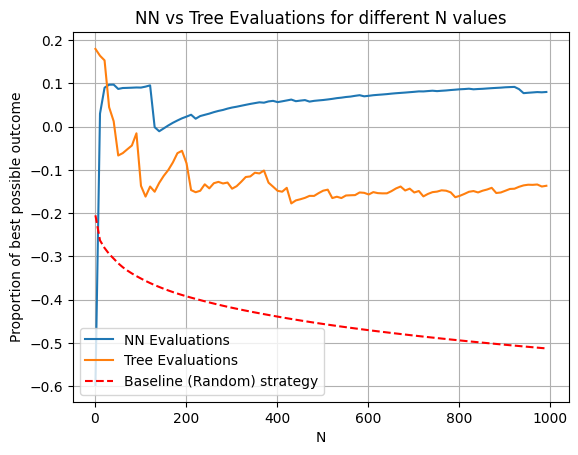

In [24]:
# plotting comparison of models@ investment strategies

time_points = range(1, 1000, 10)  

plt.plot(time_points, nn_evaluations, label = 'NN Evaluations')
plt.plot(time_points, tree_evaluations, label = 'Tree Evaluations')
plt.plot(time_points, random_strategy_evaluations, color = 'r', linestyle = '--', label = 'Baseline (Random) strategy')
plt.xlabel('N')
plt.ylabel('Proportion of best possible outcome')
plt.title('NN vs Tree Evaluations for different N values')
plt.legend()
plt.grid(True)

plt.show()


## 4. Default Minimization

### Data pre-processing

In [25]:
# creating new binary explanatory variable - represents default
y = data.loan_status.isin(["Charged Off", "Default"])
y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, stratify = y, random_state = seed) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, stratify = y_test, random_state = seed)

scaler = StandardScaler()

x_train_scaled = x_train
x_test_scaled = x_test
x_val_scaled = x_val

x_train_scaled[continuous_features_reduced] = scaler.fit_transform(x_train[continuous_features_reduced])
x_test_scaled[continuous_features_reduced] = scaler.transform(x_test[continuous_features_reduced])
x_val_scaled[continuous_features_reduced] = scaler.transform(x_val[continuous_features_reduced])

### Neural Network implementation

In [26]:

random.seed(seed)

# Dictionary to hold models
model_dict = {
    'Sigmoid Single Layer': [],
    'Sigmoid Double Layer': []
}

# Create models with varying numbers of neurons
for n_neurons in range(10, 110, 10):
    model_dict['Sigmoid Single Layer'].append(create_model(n_neurons, 'sigmoid', 1, loss = 'binary_crossentropy', classification = True))
    model_dict['Sigmoid Double Layer'].append(create_model(n_neurons, 'sigmoid', 2, loss = 'binary_crossentropy', classification = True))

# Training and evaluating models
model_histories = {}
model_val_losses = {}
model_val_recalls = {}

for key in model_dict:
    model_histories[key] = train_models(model_dict[key], x_train_scaled, y_train, epochs = 20, batch_size = 1000)
    model_val_losses[key] = evaluate_models(model_dict[key], x_val_scaled, y_val)
    model_val_recalls[key] = calculate_recalls(model_dict[key], x_val_scaled, y_val)

# Flatten the model dictionary into a single list for easy indexing
all_models = [model for model_list in model_dict.values() for model in model_list]
all_validation_losses = [loss for loss_list in model_val_losses.values() for loss in loss_list]
all_validation_recalls = [recall for recall_list in model_val_recalls.values() for recall in recall_list]

# Find the index of the model with the highest validation recall
best_model_index = np.argmax(all_validation_recalls)
best_nn_model = all_models[best_model_index]
best_validation_recall = all_validation_recalls[best_model_index]

# Determine the type and specifics of the best model
model_types = list(model_dict.keys())
models_per_type = len(model_dict['Sigmoid Single Layer'])  
best_model_type = model_types[best_model_index // models_per_type]
best_model_neurons = 10 * ((best_model_index % models_per_type) + 1)  

# Print the best model details
print(f"Best Model Type: {best_model_type}")
print(f"Best Model Neurons: {best_model_neurons}")
print(f"Best Validation Recall: {best_validation_recall}")

# Evaluate the best model on the test set
test_loss = best_nn_model.evaluate(x_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss}")




3784/3784 [==============================] - 3s 774us/step
Best Model Type: Sigmoid Double Layer
Best Model Neurons: 100
Best Validation Recall: 0.1382421875
Test Loss: 0.45879581570625305


### Neural Network experimentation and evaluation

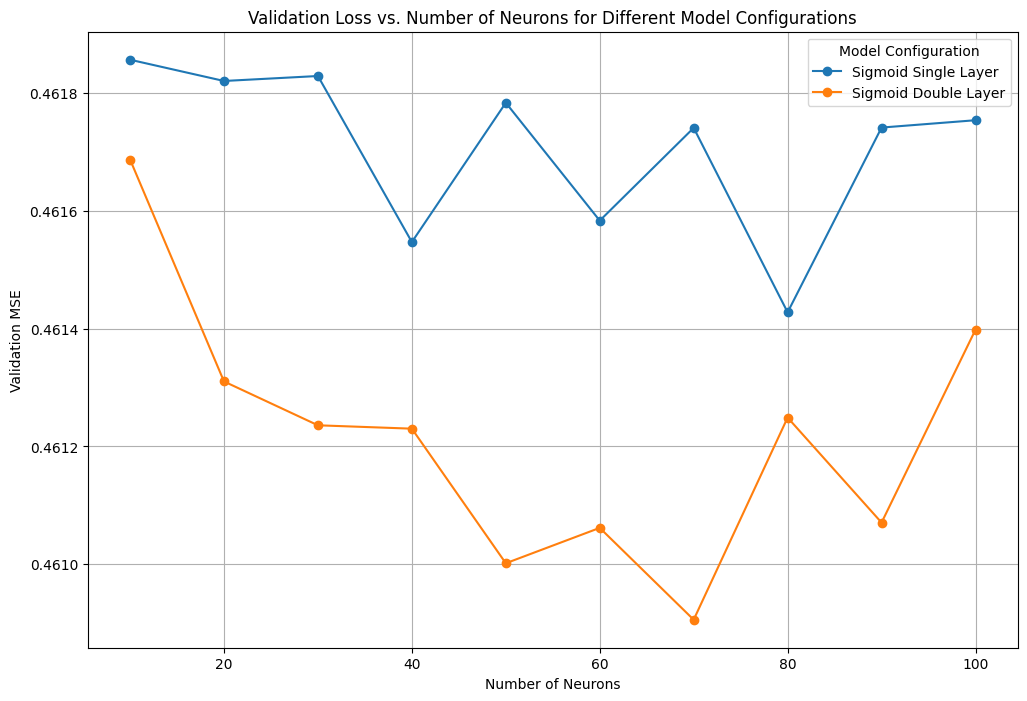

In [27]:
neurons = list(range(10, 110, 10))
plt.figure(figsize = (12, 8))
for key, losses in model_val_losses.items():
    plt.plot(neurons, losses, labe = f'{key}', marker = 'o')
plt.title('Validation Loss vs. Number of Neurons for Different Model Configurations')
plt.xlabel('Number of Neurons')
plt.ylabel('Validation MSE')
plt.legend(title='Model Configuration')
plt.grid(True)
plt.show()

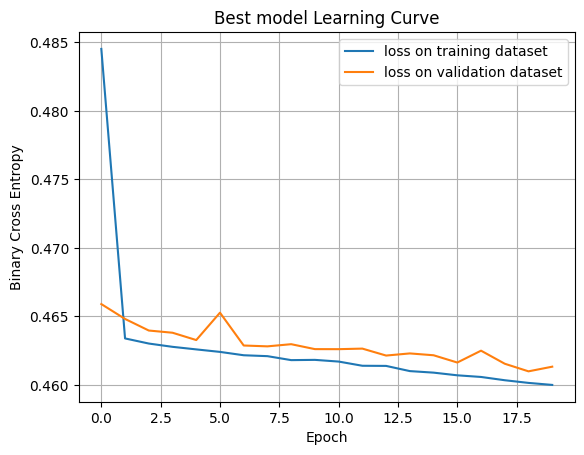

In [28]:
pyplot.title('Best model Learning Curve')
pyplot.xlabel('Epoch')
pyplot.ylabel('Binary Cross Entropy')
pyplot.plot(model_histories[best_model_type][(best_model_neurons/10 - 1).astype(int)].history['loss'], label = 'loss on training dataset')
pyplot.plot(model_histories[best_model_type][(best_model_neurons/10 - 1).astype(int)].history['val_loss'], label = 'loss on validation dataset')
pyplot.legend()
plt.grid(True)
pyplot.show()

In [29]:
# calculating model predicted probabilities of default
y_test_nn_predicted = best_nn_model.predict(x_test_scaled)
y_test_nn_predicted_prob = y_test_nn_predicted

3784/3784 [==============================] - 3s 804us/step


In [30]:
# making the classification
y_test_nn_predicted = (y_test_nn_predicted >= 0.5).astype(int)

In [31]:
# print metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_nn_predicted))


print("Precision:", precision_score(y_test, y_test_nn_predicted))
print("Accuracy:", accuracy_score(y_test, y_test_nn_predicted))
print("Recall:", recall_score(y_test, y_test_nn_predicted))
print("Baseline accuracy: ", 1 - np.sum(y_test)/len(y_test))

Confusion Matrix:
[[92567  2908]
 [21913  3687]]
Precision: 0.559059893858984
Accuracy: 0.7949948379103862
Recall: 0.1440234375
Baseline accuracy:  0.7885608094156514


### Decision Tree implementation

In [32]:
tree_models = []
best_tree_model = None
best_validation_recall = 0 

# values to experiment with 
min_sample_splits = [2, 4, 8]
min_sample_leafs = [1, 2, 4]

# grid search
for min_sample_split in min_sample_splits:
    for min_sample_leaf in min_sample_leafs:
        clf_tree = DecisionTreeClassifier(max_depth = None, min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf)
        clf_tree.fit(x_train_scaled, y_train)
        y_pred_validation = clf_tree.predict(x_val_scaled)
        validation_recall = recall_score(y_val, y_pred_validation)
        tree_models.append((clf_tree, validation_recall))
        if validation_recall > best_validation_recall:
            best_tree_model = clf_tree
            best_validation_recall = validation_recall
            best_split = min_sample_split
            best_leaf = min_sample_leaf
    

y_test_tree_predicted = best_tree_model.predict(x_test_scaled)
y_test_tree_predicted_prob = best_tree_model.predict_proba(x_test_scaled)


### Decision Tree evaluation

In [33]:
print(f"Best validation recall: {best_validation_recall}")
print("Test accuracy:", accuracy_score(y_test, y_test_tree_predicted))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_tree_predicted))
print("Test Precision:", precision_score(y_test, y_test_tree_predicted, average = 'binary'))
print("Test Recall:", recall_score(y_test, y_test_tree_predicted, average = 'binary'))
print(f"Best performing model used min_sample_split: {best_split} and min_sample_leaf: {best_leaf}")

Best validation recall: 0.31484375
Test accuracy: 0.6940821804666529
Test Confusion Matrix:
 [[75872 19603]
 [17436  8164]]
Test Precision: 0.2940180790146577
Test Recall: 0.31890625
Best performing model used min_sample_split: 2 and min_sample_leaf: 1


### Model comparison

In [34]:
# evaluating investment strategies for different values of N
nn_evaluations = [evaluate_default_rate(y_test, y_test_nn_predicted_prob, n) for n in range(1, len(y_test), 100)]
tree_evaluations = [evaluate_default_rate(y_test, y_test_tree_predicted_prob[:, 1], n) for n in range(1, len(y_test), 100)]

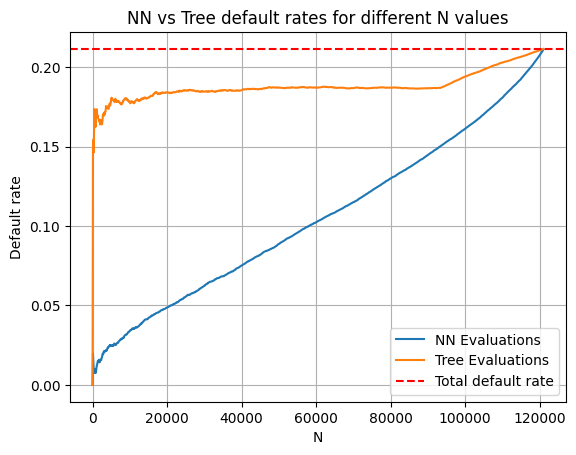

In [35]:
time_points = range(1, len(y_test), 100)
plt.plot(time_points, nn_evaluations, label = 'NN Evaluations')
plt.plot(time_points, tree_evaluations, label = 'Tree Evaluations')
plt.axhline(y = np.sum(y_test) / len(y_test), color = 'r', linestyle = '--', label = 'Total default rate')
plt.xlabel('N')
plt.ylabel('Default rate')
plt.title('NN vs Tree default rates for different N values')
plt.legend()
plt.grid(True)
plt.show()